# Natural Language Processing (NLP) usage to identify scam messages from Kaggle's Philippine Scam SMS data set

## Initial setup of Python libraries and the NLP function

In [1]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import os
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
%matplotlib inline

# Function for preprocessing
def transform_message(message):
    # Remove punctuation
    message_not_punc = ''.join([char for char in message if char not in string.punctuation])
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    message_clean = [word.lower() for word in message_not_punc.split() if word.lower() not in stop_words]
    return message_clean

def clean_text(text):
    # Remove special characters and punctuation, but preserve whole words
    cleaned = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (except spaces and words)
    cleaned = cleaned.lower()  # Convert to lowercase
    return cleaned
    
# Full pipeline function for the SVC Algorithm
def spam_detection_pipeline(data, text_column, label_column):
    # Drop rows with missing values in text_column or label_column
    data = data.dropna(subset=[text_column, label_column])

    # Vectorization: CountVectorizer -> TfidfTransformer
    vectorizer = CountVectorizer(analyzer=transform_message)
    X_counts = vectorizer.fit_transform(data[text_column])

    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_counts)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, 
        data[label_column], 
        test_size=0.3, 
        random_state=50
    )
    
    # Train the SVM model
    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    
    # Predictions
    predictions = clf.predict(X_test)
    
    # Evaluation
    print("Classification Report:\n", classification_report(y_test, predictions))
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

## Using the Support Vector Classification (SVC) algorithm-powered NLP to analyze the Philippine Scam SMS dataset

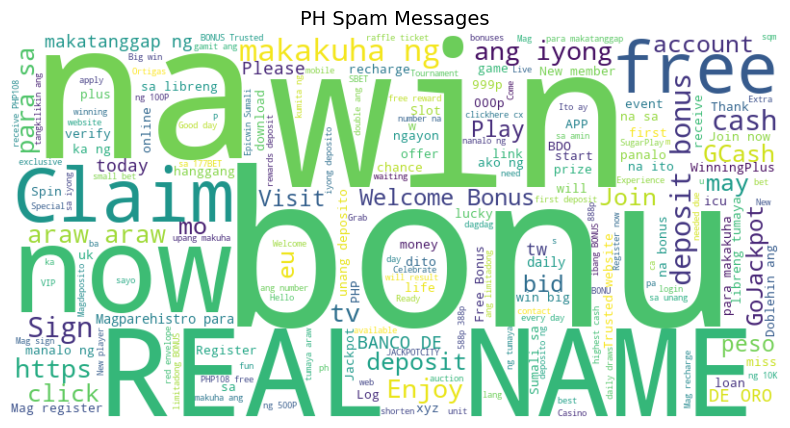

In [6]:
ph_data = pd.read_csv('Datasets/PH_SPAM.csv')
messages_ph = ph_data[['text']].copy()

# Combine all text data from the "text" column into a single string
text_data = ' '.join(ph_data['text'].dropna())

# Display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('PH Spam Messages', fontsize=14)
plt.show()

In [ ]:
# Replace '\n' with spaces first
messages_ph['text'] = messages_ph['text'].str.replace('\n', ' ', regex=True)

# Apply the clean_text function
messages_ph['text'] = messages_ph['text'].dropna().apply(clean_text)

# Load models from Dataset 1
with open('Datasets/UCI_SPAM_Model/vectorizer_dataset1.pkl', 'rb') as vec_file1:
    vectorizer1 = pickle.load(vec_file1)

with open('Datasets/UCI_SPAM_Model/tfidf_transformer_dataset1.pkl', 'rb') as tfidf_file1:
    tfidf_transformer1 = pickle.load(tfidf_file1)

with open('Datasets/UCI_SPAM_Model/svm_model_dataset1.pkl', 'rb') as model_file1:
    clf1 = pickle.load(model_file1)

# Load models from Dataset 2
with open('Datasets/Kaggle_SPAM_Model/vectorizer_dataset2.pkl', 'rb') as vec_file2:
    vectorizer2 = pickle.load(vec_file2)

with open('Datasets/Kaggle_SPAM_Model/tfidf_transformer_dataset2.pkl', 'rb') as tfidf_file2:
    tfidf_transformer2 = pickle.load(tfidf_file2)

with open('Datasets/KAGGLE_SPAM_Model/svm_model_dataset2.pkl', 'rb') as model_file2:
    clf2 = pickle.load(model_file2)

# Preprocess and predict with Dataset 1 models
X_counts1 = vectorizer1.transform(messages_ph['text'].fillna(''))
X_tfidf1 = tfidf_transformer1.transform(X_counts1)
predictions1 = clf1.predict(X_tfidf1)

# Preprocess and predict with Dataset 2 models
X_counts2 = vectorizer2.transform(messages_ph['text'].fillna(''))
X_tfidf2 = tfidf_transformer2.transform(X_counts2)
predictions2 = clf2.predict(X_tfidf2)

# Combine predictions into the dataset
results = ph_data.copy()
results['Prediction_Model1'] = predictions1
results['Prediction_Model2'] = predictions2

# Display the first few rows with predictions
print(results[['text', 'Prediction_Model1', 'Prediction_Model2']].head())

# Print result to another CSV File
results.to_csv('Datasets/PH_SPAM_predictions_combined.csv', index=False)

In [ ]:
# Define the true labels (all spam)
true_labels = ['spam'] * len(messages_ph)

# Calculate accuracy for both models
accuracy_model1 = accuracy_score(true_labels, predictions1)
accuracy_model2 = accuracy_score(true_labels, predictions2)

# Print the accuracies
print(f"Accuracy of Model 1 (Dataset 1): {accuracy_model1:.2f}")
print(f"Accuracy of Model 2 (Dataset 2): {accuracy_model2:.2f}")

In [ ]:
# Combine predictions and true labels into a DataFrame
results = messages_ph.copy()
results['True_Label'] = true_labels
results['Prediction_Model1'] = predictions1
results['Prediction_Model2'] = predictions2

# Find misclassifications for each model
misclassified_model1 = results[results['Prediction_Model1'] != results['True_Label']]
misclassified_model2 = results[results['Prediction_Model2'] != results['True_Label']]

# Find disagreements between the two models
disagreements = results[results['Prediction_Model1'] != results['Prediction_Model2']]

# Display results
print("Misclassified by Model 1:")
print(misclassified_model1[['text', 'Prediction_Model1']].head())

print("\nMisclassified by Model 2:")
print(misclassified_model2[['text', 'Prediction_Model2']].head())

print("\nDisagreements Between Model 1 and Model 2:")
print(disagreements[['text', 'Prediction_Model1', 'Prediction_Model2']].head())

# Save misclassifications by Model 1
misclassified_model1.to_csv('Datasets/misclassified_model1.csv', index=False)

# Save misclassifications by Model 2
misclassified_model2.to_csv('Datasets/misclassified_model2.csv', index=False)

# Save disagreements between Model 1 and Model 2
disagreements.to_csv('Datasets/model_disagreements.csv', index=False)